# 0 Introduction 

BME makes it possible to construct a conformational ensemble of a biomolecular system by integrating molecular simulations and experimental data. 

## Ingredients

1. A set of $M_i=1...m$ experimental measurements and associated error.
2. A conformational ensemble (e.g Molecular Dynamics or Monte Carlo simulation) consisting of $j=1...n$ samples.
3. A forward model, that is a function $F_i(X_j) $to calculate the experimental measure $i$ from the atomic coordinates $X_j$.

## Output

The ouput of the procedure is a set of optimized weights for each sample $w_1...w_n$. These weights are such that the weighted average $\langle F_i\rangle$ = $\sum_j  w_j F_i(X_j) \approx M_i$ for all the experimental data.

As we shall see in the examples below, these weights can be used to calculate any properties of interest of the system.

# 1. Data preparation

In our first example we refine the simulation using $^3$J scalar couplings.

## Experimental data
The experimental datafile [couplings_exp.dat](../data/couplings_exp.dat) consists in a header where the type of data is defined (see data type section), followed by $m=25$ scalar couplings. The first column is a user-defined label, the second is the experimental measurements and the associated error is in the third column. 


In [4]:
%cat ../data/couplings_exp.dat| head

# DATA=JCOUPLINGS
C1-H1H2  1.0  1.5
C1-H2H3  3.6  1.5
C1-H3H4  8.7  1.5
C1-H3P   8.8  1.5
C2-H1H2  1.0  1.5
C2-H2H3  4.3  1.5
C2-1H5H4 1.0  1.5
C2-2H5H4 1.0  1.5
C2-1H5P  3.8  1.5


## Calculated data 

For each sample in the simulation we calculate the experimental data using our favorite forward model. The data is collected in the file  [couplings_calc.dat](../data/couplings_calc.dat), consisting of $m+1=26$ columns (the first column being a label) and $n=20000$ rows, one per simulation frame. 

In order to better understand how the data looks like we can plot the first datapoint

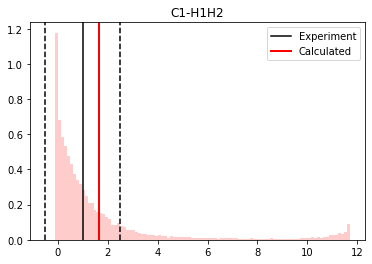

In [5]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt

# load experimental datafile
exp = np.loadtxt("../data/couplings_exp.dat",usecols=(1,2))
labels = np.loadtxt("../data/couplings_exp.dat",usecols=(0),dtype=str)

calc = np.loadtxt("../data/couplings_calc.dat")

i=1
# plot experimental average and error
_ = plt.axvline(exp[i-1,0],c='K',label="Experiment")
_ = plt.axvline(exp[i-1,0]-exp[i-1,1],c='K',linestyle="--")
_ = plt.axvline(exp[i-1,0]+exp[i-1,1],c='K',linestyle="--")

# Plot calculated average
average = np.average(calc[:,i])
_ = plt.axvline(average,c='r',label="Calculated",lw=2)

# plot histogram of the data
_ = plt.hist(calc[:,i],bins=100,density=True,alpha=0.2,color='r')
plt.title(labels[i-1])

plt.legend()


In this case we can see that the calculated average is within the experimental error, which is great. 
Let's consider now a different datapoint

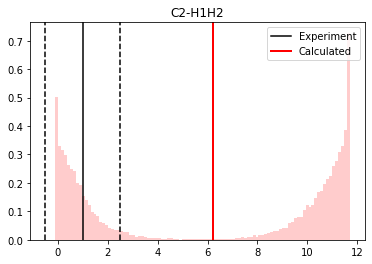

In [6]:
i=5    
# plot experimental average and error
_ = plt.axvline(exp[i-1,0],c='K',label="Experiment")
_ = plt.axvline(exp[i-1,0]-exp[i-1,1],c='K',linestyle="--")
_ = plt.axvline(exp[i-1,0]+exp[i-1,1],c='K',linestyle="--")

# Plot calculated average
average = np.average(calc[:,i])
_ = plt.axvline(average,c='r',label="Calculated",lw=2)

# plot histogram of the data
_ = plt.hist(calc[:,i],bins=100,density=True,alpha=0.2,color='r')

plt.title(labels[i-1])
plt.legend()
plt.show()
plt.close()

In this case the calculated average is clearly far away from the experiment. In general, it is convenient to plot all the datapoints together in the following fashion:


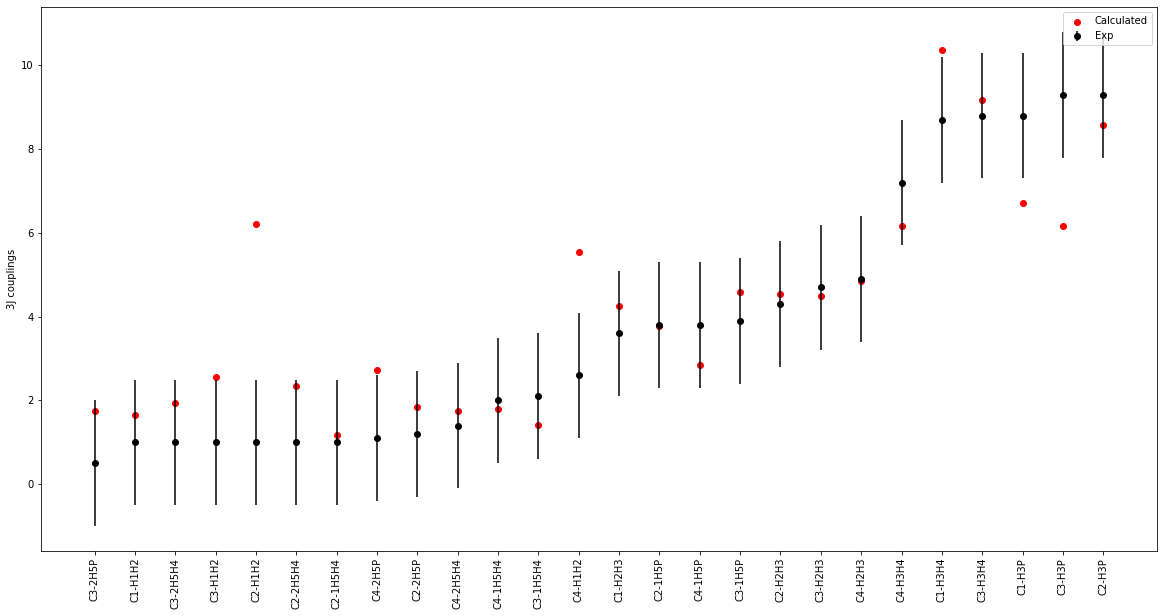

In [7]:
averages = np.average(calc[:,1:],axis=0)
idx_ordered = np.argsort(exp[:,0])

fig, ax = plt.subplots(figsize=(20, 10))

xx = range(len(labels))
plt.errorbar(xx, exp[idx_ordered,0],exp[idx_ordered,1],c='k',fmt="o",label="Exp")
plt.scatter(xx,averages[idx_ordered],c='r',label="Calculated")
plt.legend()
plt.ylabel("3J couplings")
_ = plt.xticks(xx,[labels[l] for l in idx_ordered],rotation=90)

# 2 BME reweighting

We are now ready to run the BME script. First, we have to import the module and specify the experimental/calculated datafiles 



In [8]:
import sys,os

bme_dir = os.getcwd().split("notebook")[0]
sys.path.append(bme_dir)

import BME as BME
exp_file = "%s/data/couplings_exp.dat" % bme_dir
calc_file = "%s/data/couplings_calc.dat" % bme_dir



And then we run the script itself

In [9]:
# initialize. A name must be specified 
rew = BME.Reweight("example_01")

# load the experimental and calculated datasets
rew.load(exp_file,calc_file)

# fit the data 
chi2_before, chi2_after, phi = rew.fit(theta=0.5)

# print statistics
print("Chi2 before BME %.2f" % chi2_before)
print("Chi2 after  BME %.2f" % chi2_after)
print("Fraction of effective frames %.2f" % phi)

Chi2 before BME 1.15
Chi2 after  BME 0.09
Fraction of effective frames 0.11


By definition the error before the fit is larger compared to the error after fitting. The ouptut of the fitting procedure is in essence a new set of weights.  These weights can be retrieved using the function

```
w_new = rew.get_weights()
```

And can be used to calculate any desired quantity (angle/distance distributions, averages, etc.)

We can first compare them to the initial weights  $w_0 = 1/n$


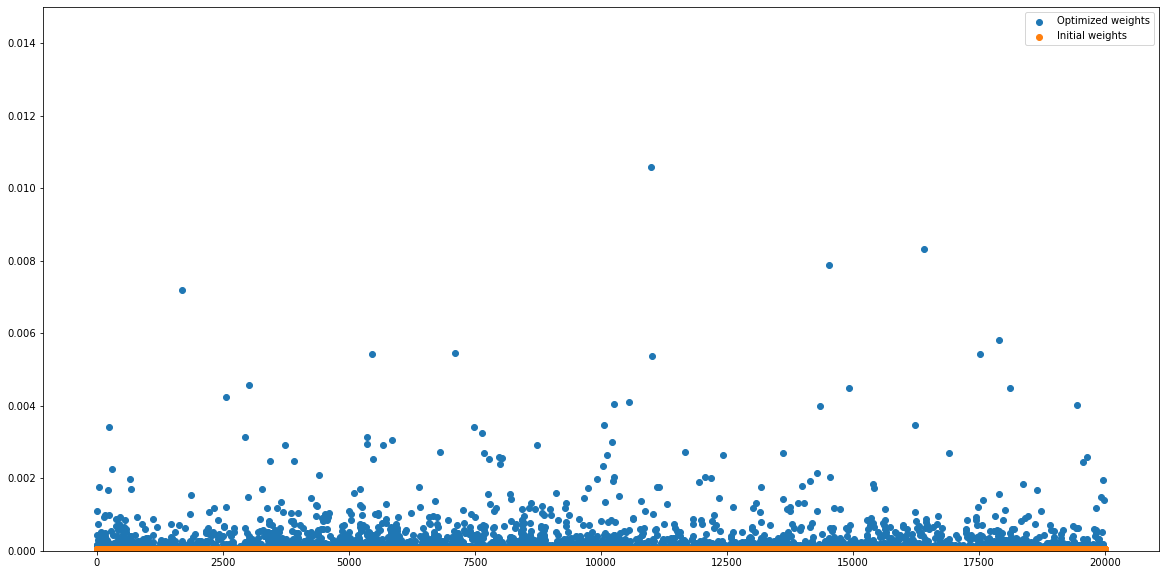

In [10]:
fig, ax = plt.subplots(figsize=(20, 10))
w0 = rew.get_w0()
w_new = rew.get_weights()

plt.scatter(range(len(w0)),w_new,label="Optimized weights")
plt.scatter(range(len(w0)),w0,label="Initial weights")
plt.ylim(0,0.015)
plt.legend()
plt.show()
plt.close()




We can see that the initial weights are all equal (each weight is 1/20000). While in the optimized weights some of them have a large weights, and many more have a weight which is almost zero. 
One possible way to quantify how much the weights are modified is given by the fraction of effective frame $\phi$.
When we choose a small parameter $theta$, the $\chi^2$ after minimization will be small, but at the cost of "throwing away" many samples (small $\phi$). 

For example, this is the expected behavior of $\phi$ and $\chi^2_{opt}/\chi^2_0$ for different values of theta.

Text(0.5, 0, 'Theta')

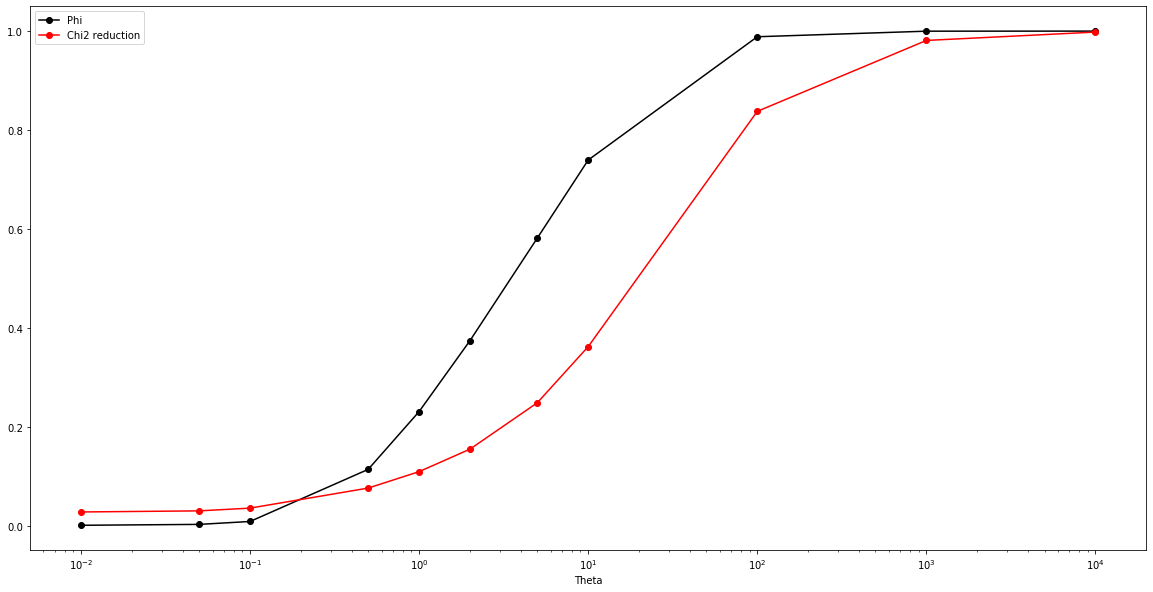

In [11]:
thetas = [0.01,0.05,0.1,0.5,1,2,5,10,100,1000,10000]
fig, ax = plt.subplots(figsize=(20, 10))

chi2 = []
phis = []
for t in thetas:
    chi2_before, chi2_after, phi = rew.fit(theta=t)
    phis.append(phi)
    chi2.append(chi2_after/chi2_before)
    #(t,chi2_after/chi2_before,c="k")
    #plt.scatter(t,phi,c="r")
plt.plot(thetas,phis,"-o",label="Phi",c="k")
plt.plot(thetas,chi2,"-o",label="Chi2 reduction",c="r")
plt.legend()
plt.xscale('log')
plt.xlabel("Theta")
#plt.xlim(0,100)


# 3. Use the optimized weights. 

The optimal weights can be used to calculate averages. BME provides a simple way of comparing the original with the optimized averages using the function

```
stats = rew.predict(exp_file,calc_file,out_file)
```

This function outputs some statistics and (optionally) a file with all the averages. Let's see it in action:

In [12]:
chi2_before, chi2_after, phi = rew.fit(theta=0.5)
w_new = rew.get_weights()


stats = rew.predict(exp_file,calc_file,"example_01_couplings")

print("%10s %10s %10s" % (" ","Original","Optimized"))
print("%10s %10.3f %10.3f" % ("Chi2",stats[0],stats[3]))
print("%10s %10.3f %10.3f" % ("RMSD",stats[1],stats[4]))
print("%10s %10d %10d" % ("Violations",stats[2],stats[5]))

print("--------------------------------------")
print("")



             Original  Optimized
      Chi2      1.152      0.088
      RMSD      1.610      0.445
Violations          7          0
--------------------------------------



The file "example_01_couplings" contains more info: the experimental average and error, and the calculated averages before and after reweighting. The last column indicates if the calculated averages are within the experimental error (0) or not (1). Therefore, 00 means that both the original and reweighted averages are within error, 10 means that only the reweighted average is within the error and so on. 


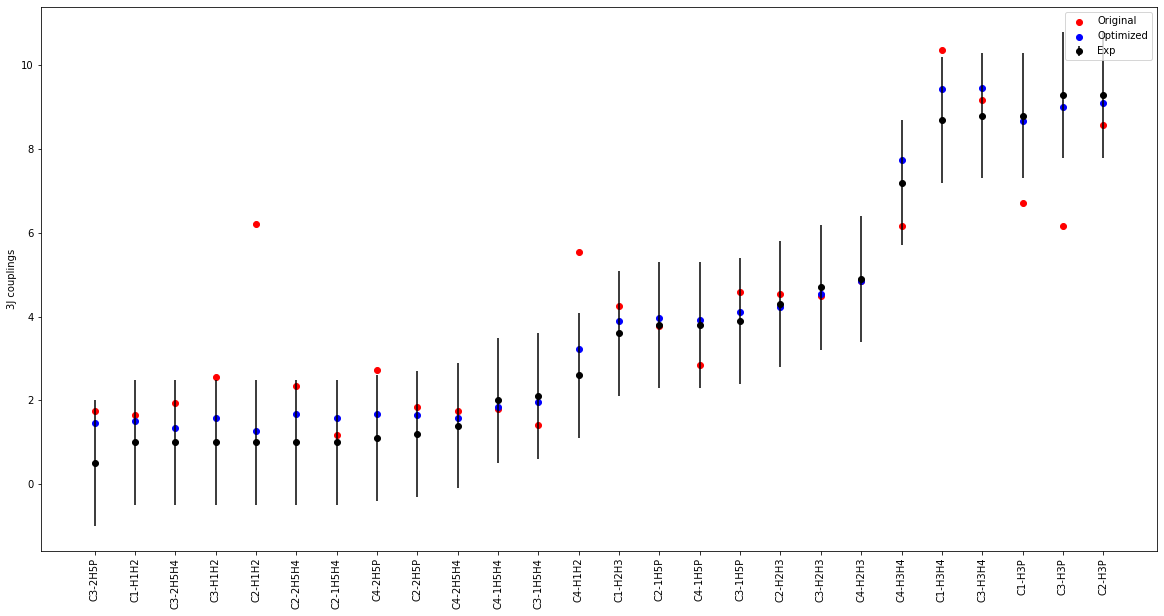

In [13]:

results = np.loadtxt("example_01_couplings",usecols=(1,2,3,4,5))
labels = np.loadtxt("example_01_couplings",usecols=(0),dtype=str)

# order by magnitude to make the plot nicer
idx_ordered = np.argsort(results[:,0])


fig, ax = plt.subplots(figsize=(20, 10))
xx = range(len(labels))
# plot experiment
plt.errorbar(xx, results[idx_ordered,0],results[idx_ordered,1],c='k',fmt="o",label="Exp")
plt.scatter(xx,results[idx_ordered,2],c='r',label="Original")
plt.scatter(xx,results[idx_ordered,3],c='b',label="Optimized")

plt.legend()
plt.ylabel("3J couplings")
_ = plt.xticks(xx,[labels[l] for l in idx_ordered],rotation=90)


This looks great. The alogrithm is doing exactly what it is supposed to do. We can further inspect C2-H1H2 and see what happens to the reweighted distribution:

20000


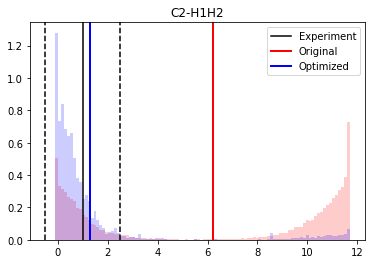

In [14]:
i=5    
# plot experimental average and error
_ = plt.axvline(results[i-1,0],c='K',label="Experiment")
_ = plt.axvline(results[i-1,0]-results[i-1,1],c='K',linestyle="--")
_ = plt.axvline(results[i-1,0]+results[i-1,1],c='K',linestyle="--")

# Plot calculated average
average = np.average(calc[:,i])
_ = plt.axvline(average,c='r',label="Original",lw=2)

print(len(w_new))
average_optimized = np.average(calc[:,i],weights=w_new)
_ = plt.axvline(average_optimized,c='b',label="Optimized",lw=2)

# plot histogram of the data
_ = plt.hist(calc[:,i],bins=100,density=True,alpha=0.2,color='r')

_ = plt.hist(calc[:,i],bins=100,density=True,alpha=0.2,color='b',weights=w_new)

plt.title(labels[i-1])
plt.legend()
plt.show()
plt.close()

So far we have *simply* performed a fit. It is interesting to check what happens when we use the optimized weights to calculate quantities not used for fitting. In this specific example we have NOE data that we can use for this purpose:

In [15]:
exp_noe_file = "../data/NOE_exp.dat"
# when the calculated datafile is large it is possible to read a compressed file 
#(using .zip or bz2 or wathever pandas can read)
calc_noe_file = "../data/NOE_calc.dat.zip"

stats_noe = rew.predict(exp_noe_file,calc_noe_file,"example_01_noe")


print("%10s %10s %10s" % (" ","Original","Optimized"))
print("%10s %10.3f %10.3f" % ("Chi2",stats_noe[0],stats_noe[3]))
print("%10s %10.3f %10.3f" % ("RMSD",stats_noe[1],stats_noe[4]))
print("%10s %10d %10d" % ("Violations",stats_noe[2],stats_noe[5]))

print("--------------------------------------")
print("")


             Original  Optimized
      Chi2      3.147      1.991
      RMSD      0.444      0.352
Violations         16         10
--------------------------------------



This also looks good: improving the agreement with 3J couplings also improve the agreement with NOE. We can do the same plot as before to see what happens to the individual NOE averages.

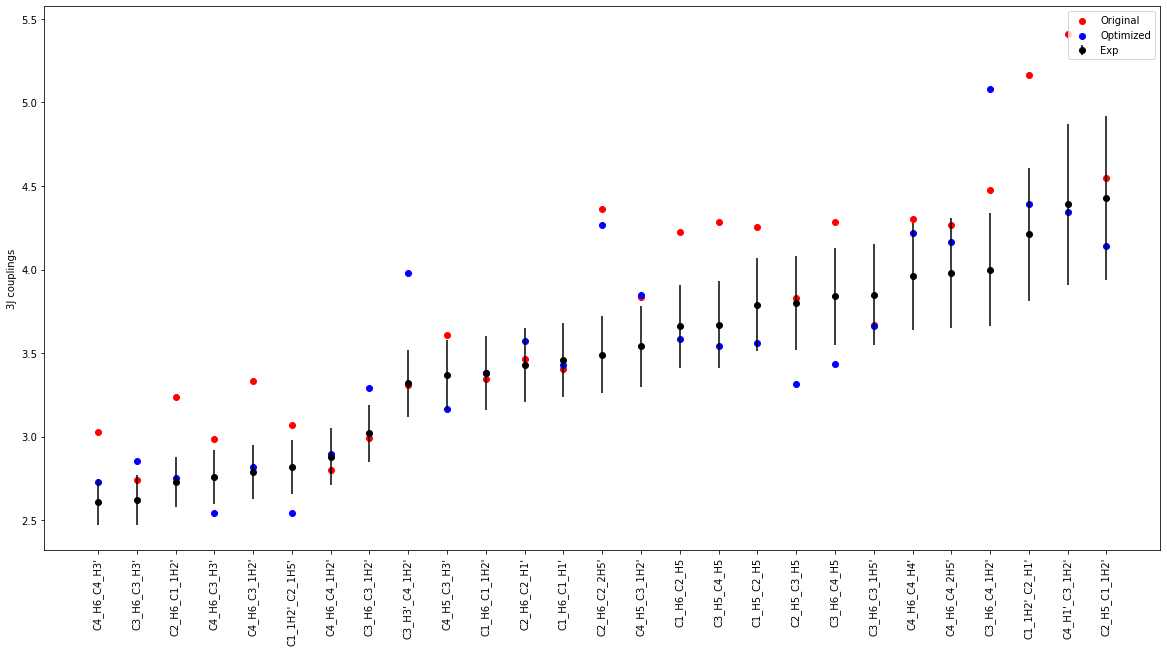

In [16]:
results = np.loadtxt("example_01_noe",usecols=(1,2,3,4,5))
labels = np.loadtxt("example_01_noe",usecols=(0),dtype=str)

idx_ordered = np.argsort(results[:,0])

fig, ax = plt.subplots(figsize=(20, 10))

xx = range(len(labels))
plt.errorbar(xx, results[idx_ordered,0],results[idx_ordered,1],c='k',fmt="o",label="Exp")
plt.scatter(xx,results[idx_ordered,2],c='r',label="Original")
plt.scatter(xx,results[idx_ordered,3],c='b',label="Optimized")

plt.legend()
plt.ylabel("3J couplings")
_ = plt.xticks(xx,[labels[l] for l in idx_ordered],rotation=90)


# 4. Other comments

-  A good way of estimating an appropriate value for $\theta$ is by cross-validation. See [example_02](example_02.ipynb). 
-  Some type of data such as residual dipolar couplings need to be rescaled, SAXS data are shifted and rescaled, while NOE distances has to be averaged properly. See [example_03](example_03.ipynb) for a detailed discussion.
-  Multiple data files can be loaded simply by calling the load function multiple times, as shown in [example_02](example_02.ipynb). 
-  A log file containing information on the fit is produced when initializing a Reweight class.